In [1]:
%load_ext autoreload 
%autoreload 2 

In [5]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # for subplots
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import tensorflow as tf

from src.data_processing.processors.TrainingProcessor import TrainingProcessor

In [13]:
DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/data_pipeline_full_dataset/datasets/full_dataset.parquet.gzip'
MODEL_PATH = "/projects/p31961/ENIGMA/results/experiments/dopamine_full_sequence_stacked_lstm_01/models/dopamine_full_sequence_stacked_lstm_01"

In [4]:
data = pd.read_parquet(DATA_PATH)
data

,time,sex_M,day,trial,trial_count,learning_phase,event_cue,event_escape,event_avoid,action_escape,...,mouse_id_4,mouse_id_5,mouse_id_6,mouse_id_7,mouse_id_8,mouse_id_9,mouse_id_10,mouse_id_11,mouse_id_12,mouse_id_13
0,-25.000000,0,5,0,115,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,-24.901531,0,5,0,115,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,-24.803064,0,5,0,115,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,-24.704596,0,5,0,115,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,-24.606127,0,5,0,115,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5858795,19.606127,0,4,1,87,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5858796,19.704596,0,4,1,87,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5858797,19.803064,0,4,1,87,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5858798,19.901531,0,4,1,87,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_processor = (TrainingProcessor(data)
                .query_sensor_and_sort_trials_by_subject(sensor='DA')
                .split_train_val_test_by_subject(target='signal', shuffle=False)
                )

In [18]:
train_processor.train_x.shape

(1886120, 27)

In [14]:
model = tf.keras.models.load_model(MODEL_PATH)

model.compile(optimizer='adam', loss='mse', metrics=[
        'mae', 'mse', 'mape', 'cosine_similarity'])

2023-08-08 11:38:15.391046: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38222 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:06:00.0, compute capability: 8.0
2023-08-08 11:38:15.392882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38222 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:2f:00.0, compute capability: 8.0
/home/mds8301/.conda/envs/enigma/lib/python3.11/site-packages/keras/layers/core/lambda_layer.py:325: UserWarning: src.models.StackedLSTM is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(
2023-08-08 11:38:17.468624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed 

In [15]:
model.summary()

Model: "stacked_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Lambda_1 (Lambda)           multiple                  0         
                                                                 
 LSTM_1 (LSTM)               multiple                  12096     
                                                                 
 LSTM_2 (LSTM)               multiple                  23544     
                                                                 
 Dense_output (Dense)        multiple                  55        
                                                                 
Total params: 35,695
Trainable params: 35,695
Non-trainable params: 0
_________________________________________________________________


In [40]:
predicted_signal = model.predict(train_processor.test_x)

20548/20548 [==============================] - 38s 2ms/step


In [42]:
test_df = (
    train_processor.test_x
    .assign(
        true_signal=train_processor.test_y,
        predicted_signal = predicted_signal
        )
              )

In [43]:
test_df.columns

Index(['time', 'sex_M', 'day', 'trial', 'trial_count', 'learning_phase',
       'event_cue', 'event_escape', 'event_avoid', 'action_escape',
       'action_avoid', 'latency', 'event_shock', 'mouse_id_0', 'mouse_id_1',
       'mouse_id_2', 'mouse_id_3', 'mouse_id_4', 'mouse_id_5', 'mouse_id_6',
       'mouse_id_7', 'mouse_id_8', 'mouse_id_9', 'mouse_id_10', 'mouse_id_11',
       'mouse_id_12', 'mouse_id_13', 'true_signal', 'predicted_signal'],
      dtype='object')

In [44]:
train_processor.testing_subjects

['mouse_id_11', 'mouse_id_12', 'mouse_id_13']

In [65]:
query = test_df.query("mouse_id_11 == 1 & event_cue == 1 & action_avoid==1")
query = query.melt(id_vars = query.drop(columns = ['predicted_signal', 'true_signal']).columns, value_vars= ['predicted_signal', 'true_signal'], value_name = "signal", var_name = 'signal_type')
query

,time,sex_M,day,trial,trial_count,learning_phase,event_cue,event_escape,event_avoid,action_escape,...,mouse_id_6,mouse_id_7,mouse_id_8,mouse_id_9,mouse_id_10,mouse_id_11,mouse_id_12,mouse_id_13,signal_type,signal
0,-25.000000,1,2,1,30,0,1,0,0,0,...,0,0,0,0,0,1,0,0,predicted_signal,-0.074293
1,-24.901531,1,2,1,30,0,1,0,0,0,...,0,0,0,0,0,1,0,0,predicted_signal,-0.076042
2,-24.803064,1,2,1,30,0,1,0,0,0,...,0,0,0,0,0,1,0,0,predicted_signal,-0.078028
3,-24.704596,1,2,1,30,0,1,0,0,0,...,0,0,0,0,0,1,0,0,predicted_signal,-0.079521
4,-24.606127,1,2,1,30,0,1,0,0,0,...,0,0,0,0,0,1,0,0,predicted_signal,-0.081524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73275,19.606127,1,7,28,201,2,1,0,0,0,...,0,0,0,0,0,1,0,0,true_signal,-0.693317
73276,19.704596,1,7,28,201,2,1,0,0,0,...,0,0,0,0,0,1,0,0,true_signal,-1.208631
73277,19.803064,1,7,28,201,2,1,0,0,0,...,0,0,0,0,0,1,0,0,true_signal,-1.242194
73278,19.901531,1,7,28,201,2,1,0,0,0,...,0,0,0,0,0,1,0,0,true_signal,-1.117552


<Axes: xlabel='time', ylabel='signal'>

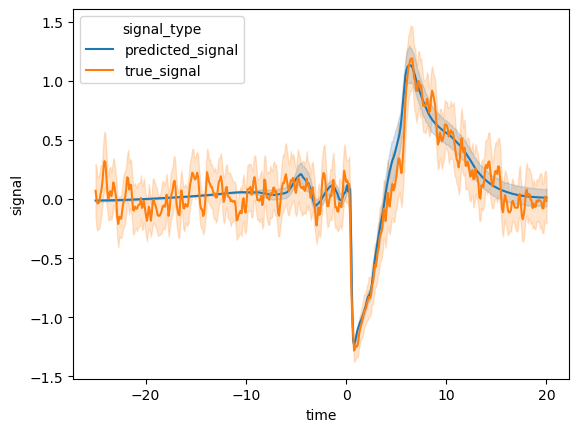

In [66]:
sns.lineplot(data = query, x = 'time', y = 'signal', hue = 'signal_type')
# sns.lineplot(data = query, x = 'time', y = 'predicted_signal')

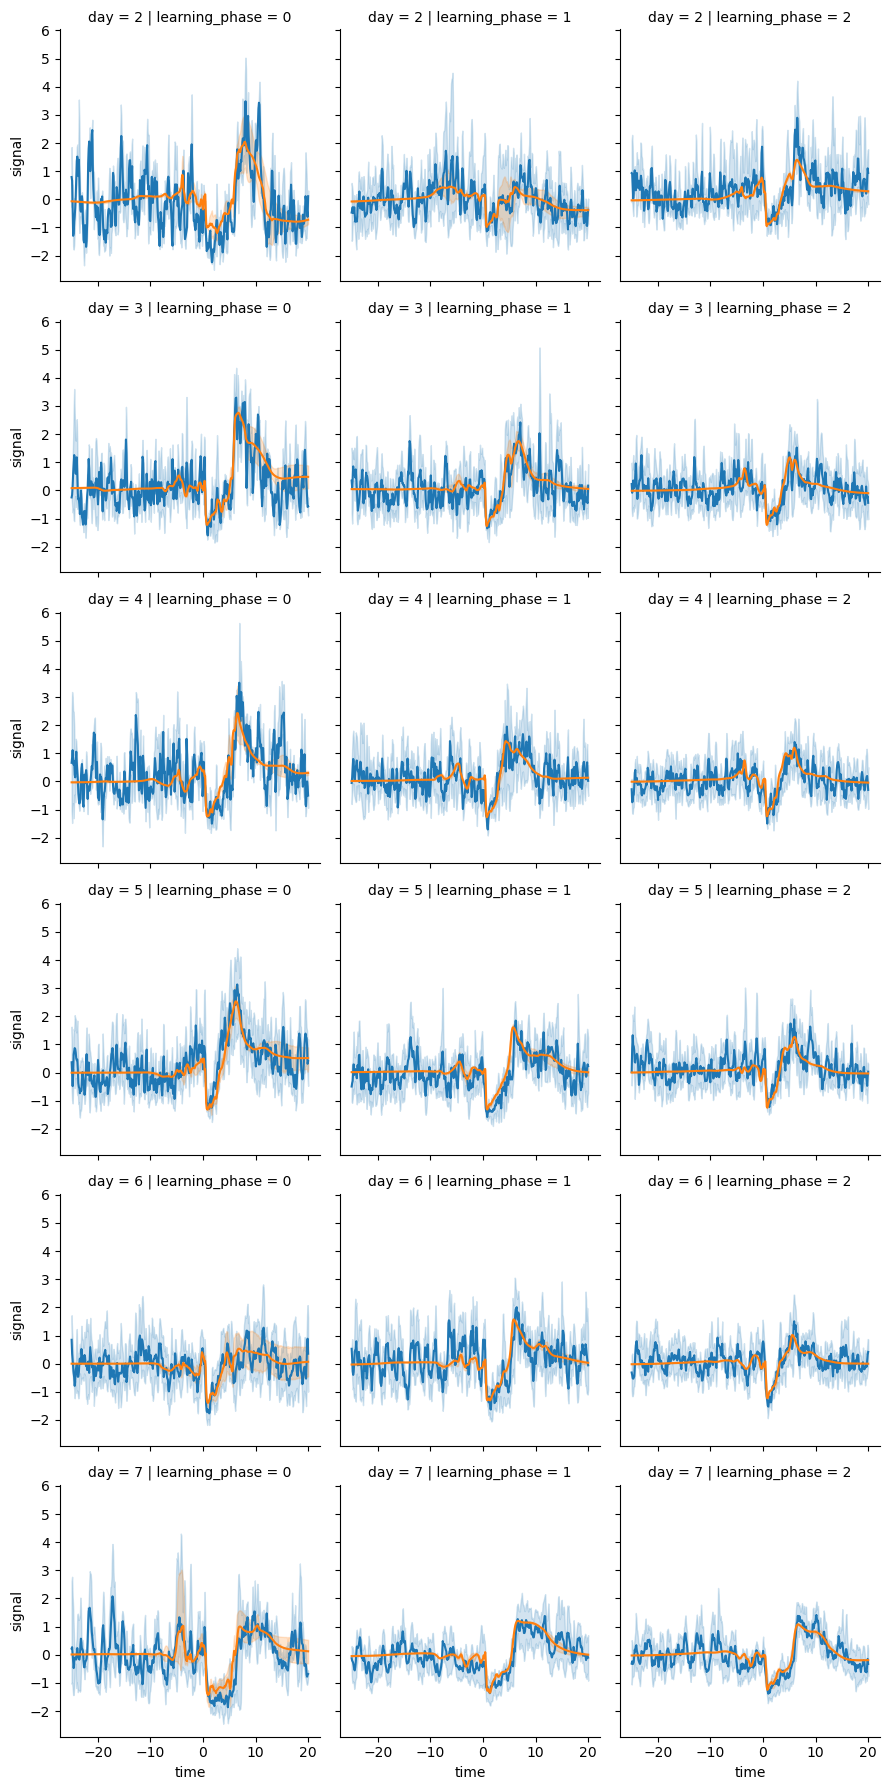

In [75]:
facet = sns.FacetGrid(query, row = 'day', col = "learning_phase")
facet.map_dataframe(sns.lineplot, x = 'time', y = 'signal', hue = 'signal_type', hue_order = ["true_signal", "predicted_signal"])

In [78]:
# save data from experiment
train_processor.training_subjects
train_processor.validation_subjects
train_processor.testing_subjects

['mouse_id_11', 'mouse_id_12', 'mouse_id_13']

In [79]:
cats = {'training_subjects': train_processor.training_subjects,
        'validation_subjects': train_processor.validation_subjects,
        'testing_subjects': train_processor.testing_subjects}

cats

{'training_subjects': ['mouse_id_0',
  'mouse_id_1',
  'mouse_id_2',
  'mouse_id_3',
  'mouse_id_4',
  'mouse_id_5',
  'mouse_id_6',
  'mouse_id_7',
  'mouse_id_8'],
 'validation_subjects': ['mouse_id_9', 'mouse_id_10'],
 'testing_subjects': ['mouse_id_11', 'mouse_id_12', 'mouse_id_13']}

In [80]:
cats_df = pd.DataFrame(cats)

ValueError: All arrays must be of the same length